## Testa a utilização dos modelos LSTM ou Dense

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import pickle
import warnings
warnings.filterwarnings('ignore')

## Função filtra_usuario_separa_x_epoca_y()



In [4]:
def filtra_usuario_separa_x_epoca_y(df, username="*", usuarios_exclusao=[]):
    """
    Prepara os dados filtrando por usuário e criando features históricas
    
    Args:
        df: DataFrame com os dados originais
        username: Nome do usuário para filtrar ("*" para todos os usuários)
    
    Returns:
        tuple: (features_sequenciais, features_contextuais, target)
    """
    print(f"Processando dados para usuário: {username}")
    
    # Filtrar por usuário se especificado

    if username != "*":
        df_filtro = df[df["usuario"] == username].copy()
        print(f"Registros após filtro de usuário: {len(df_filtro)}")
    else:
        df_filtro = df[~df["usuario"].isin(usuarios_exclusao)].copy()
        print(f"Processando todos os usuários (excluindo {len(usuarios_exclusao)} usuários): {len(df_filtro)} registros")

        # Ordenar por data/hora para manter sequência temporal
        df_filtro = df_filtro.sort_values(["usuario", "Dia", "Mes", "Ano", "DataHoraCriacao"])

    # Criar features históricas (últimos 3 casos de uso)
    print("Criando features históricas...")
    for shift in range(1, 3):
        df_filtro[f"casoDeUso_{shift}"] = df_filtro.groupby(["usuario", "Dia", "Mes", "Ano"])["casoDeUso"].shift(shift).fillna("vazio")

    # Remover registros com NaN e resetar índice
    df_filtro = df_filtro.dropna().reset_index(drop=True)
    print(f"Registros após limpeza: {len(df_filtro)}")

    # Separar target
    df_target = df_filtro["casoDeUso"]

    # Preparar features sequenciais (remover colunas não necessárias)
    cols_a_remover = ["DataHoraCriacao", "Dia", "Mes", "Ano", "casoDeUso", "usuario", "PeriodoDoMes"]
    df_x = df_filtro.drop(columns=cols_a_remover)

    # Preparar features contextuais (período do mês)
    df_epoca = df_filtro[["PeriodoDoMes"]].copy()

    return df_x, df_epoca, df_target

## Função aplica_OneHotEncoder_x

In [5]:
def aplica_OneHotEncoder_x(df, cols):
    """
    Aplica One-Hot Encoding nas colunas especificadas
    
    Args:
        df: DataFrame para processar
        cols: Lista de colunas para aplicar encoding
    
    Returns:
        tuple: (DataFrame com encoding aplicado, OneHotEncoder fitted)
    """
    print(f"Aplicando One-Hot Encoding em: {cols}")
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    df_ohe = pd.DataFrame(
        ohe.fit_transform(df[cols]), 
        columns=ohe.get_feature_names_out(cols), 
        index=df.index
    )
    return pd.concat([df.drop(columns=cols), df_ohe], axis=1), ohe

## Função preprocessar_dados

In [6]:
def preprocessar_dados(data_path, username="*", usuarios_exclusao=[], test_size=0.4, random_state=42):
    """
    Pipeline completo de preprocessamento de dados
    
    Args:
        data_path: Caminho para o arquivo CSV
        username: Usuário para filtrar
        test_size: Proporção para teste
        random_state: Seed para reprodutibilidade
    
    Returns:
        tuple: Dados de treino e teste preprocessados
    """
    print("=== INICIANDO PREPROCESSAMENTO ===")
    
    # Carregar dados
    print(f"Carregando dados de: {data_path}")
    df = pd.read_csv(
        data_path, 
        sep=';', 
        encoding='utf-8', 
        parse_dates=['DataHoraCriacao'], 
        dayfirst=True
    )
    print(f"Dataset carregado: {df.shape}")
    
    # Verificar distribuição das classes
    print("\nDistribuição das classes:")
    print(df['casoDeUso'].value_counts().head(10))
    
    # Processar dados
    df_x, df_epoca, serie_y = filtra_usuario_separa_x_epoca_y(df, username, usuarios_exclusao)
    
    # Analisar distribuição das classes
    stats = analisar_distribuicao_classes(serie_y, username)
    
    # Aplicar One-Hot Encoding nas features históricas
    # df_x, ohe_x = aplica_OneHotEncoder_x(df_x, ["casoDeUso_1", "casoDeUso_2", "casoDeUso_3"])
    df_x, ohe_x = aplica_OneHotEncoder_x(df_x, ["casoDeUso_1", "casoDeUso_2"])
    
    # Mapear período do mês para valores numéricos e normalizar
    print("Processando features contextuais...")
    df_epoca["PeriodoDoMes"] = df_epoca["PeriodoDoMes"].map({
        'antes_folha': 0, 
        'dia_folha': 1, 
        'apos_folha': 2
    })
    
    # Normalizar features contextuais
    scaler_epoca = StandardScaler()
    df_epoca_scaled = pd.DataFrame(
        scaler_epoca.fit_transform(df_epoca), 
        columns=df_epoca.columns,
        index=df_epoca.index
    )
    
    # Converter target para One-Hot
    y_one_hot, ohe_y = aplica_OneHotEncoder_x(serie_y.to_frame(), ["casoDeUso"])
    
    # Normalizar features sequenciais
    print("Normalizando features sequenciais...")
    scaler_seq = StandardScaler()
    df_x_scaled = pd.DataFrame(
        scaler_seq.fit_transform(df_x),
        columns=df_x.columns,
        index=df_x.index
    )
    
    # Verificar se é possível fazer divisão estratificada
    print("Dividindo dados em treino e teste...")
    
    # Verificar classes com poucas amostras
    class_counts = serie_y.value_counts()
    classes_com_poucas_amostras = class_counts[class_counts < 2]
    
    if len(classes_com_poucas_amostras) > 0:
        print(f"⚠️ Aviso: {len(classes_com_poucas_amostras)} classes com apenas 1 amostra:")
        print(classes_com_poucas_amostras.head())
        print("Removendo classes com poucas amostras para permitir estratificação...")
        
        # Filtrar classes com pelo menos 2 amostras
        classes_validas = class_counts[class_counts >= 2].index
        mask = serie_y.isin(classes_validas)
        
        df_x_scaled = df_x_scaled[mask]
        df_epoca_scaled = df_epoca_scaled[mask]
        y_one_hot = y_one_hot[mask]
        serie_y = serie_y[mask]
        
        print(f"Dados após filtro: {len(df_x_scaled)} amostras, {len(serie_y.unique())} classes")
        
        # Recriar one-hot encoding para classes restantes
        y_one_hot, ohe_y = aplica_OneHotEncoder_x(serie_y.to_frame(), ["casoDeUso"])
    
    # Tentar divisão estratificada, se falhar usar divisão simples
    try:
        X_train_seq, X_test_seq, X_train_epoch, X_test_epoch, y_train, y_test = train_test_split(
            df_x_scaled, df_epoca_scaled, y_one_hot, 
            test_size=test_size, 
            random_state=random_state,
            stratify=serie_y  # Estratificação para manter proporção das classes
        )
        print("✅ Divisão estratificada realizada com sucesso")
    except ValueError as e:
        print(f"⚠️ Não foi possível fazer divisão estratificada: {str(e)}")
        print("Realizando divisão simples...")
        X_train_seq, X_test_seq, X_train_epoch, X_test_epoch, y_train, y_test = train_test_split(
            df_x_scaled, df_epoca_scaled, y_one_hot, 
            test_size=test_size, 
            random_state=random_state
        )
    
    print(f"Treino: {X_train_seq.shape[0]} samples")
    print(f"Teste: {X_test_seq.shape[0]} samples")
    
    return (X_train_seq, X_test_seq, X_train_epoch, X_test_epoch, 
            y_train, y_test, scaler_seq, scaler_epoca, ohe_x, ohe_y)


## função criar_modelo_hibrido

In [7]:
def criar_modelo_hibrido(input_seq_shape, input_epoch_shape, output_shape, 
                        use_lstm=True, lstm_units=64, dense_units=[128, 64], 
                        dropout_rate=0.3):
    """
    Cria modelo híbrido com opção de usar LSTM ou Dense
    
    Args:
        input_seq_shape: Shape das features sequenciais
        input_epoch_shape: Shape das features contextuais
        output_shape: Número de classes de saída
        use_lstm: Se True, usa LSTM; se False, usa Dense
        lstm_units: Unidades LSTM
        dense_units: Lista com unidades das camadas Dense
        dropout_rate: Taxa de dropout
    
    Returns:
        Model: Modelo compilado
    """
    print(f"=== CRIANDO MODELO {'LSTM' if use_lstm else 'DENSE'} HÍBRIDO ===")
    
    # Input para features sequenciais
    input_seq = Input(shape=(input_seq_shape,), name='input_sequence')
    input_epoch = Input(shape=(input_epoch_shape,), name='input_epoch')
    
    if use_lstm:
        # Para LSTM, precisamos reshapear para 3D (samples, timesteps, features)
        # Assumindo que cada feature é um timestep
        x = Reshape((input_seq_shape, 1))(input_seq)
        x = LSTM(lstm_units, return_sequences=False, dropout=dropout_rate)(x)
        print(f"Usando LSTM com {lstm_units} unidades")
    else:
        # Usar camadas Dense tradicionais
        x = input_seq
        for i, units in enumerate(dense_units):
            x = Dense(units, activation='relu', name=f'dense_{i+1}')(x)
            x = Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
        print(f"Usando Dense layers: {dense_units}")
    
    # Combinar features sequenciais com contextuais
    combined = Concatenate(name='concatenate')([x, input_epoch])
    
    # Camada de saída
    output = Dense(output_shape, activation='softmax', name='output')(combined)
    
    # Criar modelo
    model = Model(inputs=[input_seq, input_epoch], outputs=output)
    
    # Compilar modelo
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    print("Modelo criado e compilado!")
    print(f"Parâmetros totais: {model.count_params():,}")
    
    return model


## função treinar_modelo

In [8]:
def treinar_modelo(model, X_train_seq, X_train_epoch, y_train, 
                  epochs=50, validation_split=0.2, verbose=1):
    """
    Treina o modelo com callbacks para early stopping e redução de learning rate
    
    Args:
        model: Modelo a ser treinado
        X_train_seq, X_train_epoch: Features de treino
        y_train: Target de treino
        epochs: Número máximo de épocas
        validation_split: Proporção para validação
        verbose: Verbosidade do treinamento
    
    Returns:
        History: Histórico do treinamento
    """
    print("=== INICIANDO TREINAMENTO ===")
    
    # Callbacks para melhorar o treinamento
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Treinar modelo
    history = model.fit(
        [X_train_seq, X_train_epoch], 
        y_train,
        epochs=epochs,
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=verbose,
        batch_size=32
    )
    
    print("Treinamento concluído!")
    return history


## Função avaliar_modelo

In [9]:
def avaliar_modelo(model, X_test_seq, X_test_epoch, y_test, ohe_y):
    """
    Avalia o modelo com múltiplas métricas
    
    Args:
        model: Modelo treinado
        X_test_seq, X_test_epoch: Features de teste
        y_test: Target de teste
        ohe_y: OneHotEncoder do target para obter nomes das classes
    
    Returns:
        dict: Dicionário com métricas de avaliação
    """
    print("=== AVALIANDO MODELO ===")
    
    # Predições
    y_pred_proba = model.predict([X_test_seq, X_test_epoch])
    y_pred = np.argmax(y_pred_proba, axis=-1)
    y_test_labels = np.argmax(y_test.values, axis=-1)
    
    # Métricas básicas
    accuracy = accuracy_score(y_test_labels, y_pred)
    print(f"Acurácia: {accuracy * 100:.2f}%")
    
    # Relatório de classificação
    class_names = ohe_y.get_feature_names_out(['casoDeUso'])
    class_names = [name.replace('casoDeUso_', '') for name in class_names]
    
    print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
    print(classification_report(y_test_labels, y_pred, target_names=class_names))
    
    # Matriz de confusão
    cm = confusion_matrix(y_test_labels, y_pred)
    
    return {
        'accuracy': accuracy,
        'y_pred': y_pred,
        'y_test': y_test_labels,
        'confusion_matrix': cm,
        'class_names': class_names,
        'y_pred_proba': y_pred_proba
    }


## Função salvar_modelo

In [10]:
def salvar_modelo(model, scaler_seq, scaler_epoca, ohe_x, ohe_y, path_base='artefatos_modelo'):
    """
    Salva o modelo Keras e os transformadores necessários para inferência futura.
    
    Args:
        model: Modelo Keras treinado.
        scaler_seq: Scaler das features sequenciais.
        scaler_epoca: Scaler das features contextuais.
        ohe_x: OneHotEncoder das features históricas.
        ohe_y: OneHotEncoder do target.
        path_base: Pasta/caminho base para salvar os arquivos.
    """
    import os
    os.makedirs(path_base, exist_ok=True)

    # Salva o modelo keras
    model.save(os.path.join(path_base, 'modelo.keras'))

    # Salva os transformadores com pickle
    with open(os.path.join(path_base, 'scaler_seq.pkl'), 'wb') as f:
        pickle.dump(scaler_seq, f)

    with open(os.path.join(path_base, 'scaler_epoca.pkl'), 'wb') as f:
        pickle.dump(scaler_epoca, f)

    with open(os.path.join(path_base, 'ohe_x.pkl'), 'wb') as f:
        pickle.dump(ohe_x, f)

    with open(os.path.join(path_base, 'ohe_y.pkl'), 'wb') as f:
        pickle.dump(ohe_y, f)

    print(f"\n✅ Modelo e transformadores salvos na pasta '{path_base}'!")


## Função plotar_resultados

In [11]:
def plotar_resultados(history, results):
    """
    Plota gráficos de treinamento e matriz de confusão
    
    Args:
        history: Histórico do treinamento
        results: Resultados da avaliação
    """
    print("Gerando visualizações...")
    
    # Configurar estilo dos gráficos
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Acurácia durante treinamento
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(history.history['accuracy'], label='Treino', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validação', linewidth=2)
    plt.title('Acurácia Durante o Treinamento', fontsize=14, fontweight='bold')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Perda durante treinamento
    ax2 = plt.subplot(2, 3, 2)
    plt.plot(history.history['loss'], label='Treino', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validação', linewidth=2)
    plt.title('Perda Durante o Treinamento', fontsize=14, fontweight='bold')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Learning Rate (se disponível)
    ax3 = plt.subplot(2, 3, 3)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], linewidth=2, color='red')
        plt.title('Learning Rate', fontsize=14, fontweight='bold')
        plt.xlabel('Épocas')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Learning Rate\nnão disponível', 
                ha='center', va='center', fontsize=12)
        plt.title('Learning Rate', fontsize=14, fontweight='bold')
    
    # 4. Matriz de confusão
    ax4 = plt.subplot(2, 3, (4, 6))
    sns.heatmap(
        results['confusion_matrix'], 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=results['class_names'],
        yticklabels=results['class_names']
    )
    plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    
    # 5. Distribuição de confiança das predições
    ax5 = plt.subplot(2, 3, 5)
    max_proba = np.max(results['y_pred_proba'], axis=1)
    plt.hist(max_proba, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribuição de Confiança das Predições', fontsize=14, fontweight='bold')
    plt.xlabel('Confiança Máxima')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



## Função Principal que executa todo o pipeline

Esta função:

1 - Préprocessa os dados:

1.1 - filtrando os usuários que serão utilizados para treinamento

1.2 - Gerando linhas com dois casos de uso históricos maio o caso de uso alvo/target

1.3 - Separa a massa de dados de treino e avaliação do treino

2 - Cria um modelo hibrido, podendo ser:

2.1 - LSTM

2.2 - Dense layers

3 - Treina o modelo hibrido com os dados do passo 1

4 - Avaliar o modelo treinado com a base de dados separada para avaliação no passo 1

5 - Plota gráficos de avaliação dos resultados

6 - Salva o modelo e seus parâmetros de configuração para posterior utilização nas previsões


In [14]:
def main(data_path='dados.csv', 
         usuario='*', # Nome do usuário ou '*' para todos
         use_lstm=False,  # Usar Dense layers ou LSTM
         epochs=50,
         plotar_resultado=True, # Se deve ou não chamar o método plotar_resultados()
         usuarios_exclusao=[] # No caso de usar '*' em usuario, lista de exclusão da base de dados.  Não carregar os dados desses.
         ):  
    """
    Função principal que executa todo o pipeline
    
    Args:
        data_path: Caminho para os dados
        usuario: Usuário para filtrar
        use_lstm: Se usar LSTM ou Dense layers
        epochs: Número de épocas para treinamento
        plotar_resultado: Se deve ou não chamar o método plotar_resultados() ao final do treino e testes
        usuarios_exclusao: Lista de usuários a não serem considerados se o usuario='*'
    """
    try:
        # Preprocessamento
        (X_train_seq, X_test_seq, X_train_epoch, X_test_epoch, 
         y_train, y_test, scaler_seq, scaler_epoca, ohe_x, ohe_y) = preprocessar_dados(data_path, usuario, usuarios_exclusao)
        
        # Criar modelo
        modelo = criar_modelo_hibrido(
            input_seq_shape=X_train_seq.shape[1],
            input_epoch_shape=X_train_epoch.shape[1],
            output_shape=y_train.shape[1],
            use_lstm=use_lstm
        )
        
        print("\n\n=== ARQUITETURA DO MODELO ===")
        modelo.summary()
        
        # Treinar modelo
        historico = treinar_modelo(
            modelo, X_train_seq, X_train_epoch, y_train, 
            epochs=epochs
        )
        
        # Avaliar modelo
        resultados = avaliar_modelo(
            modelo, X_test_seq, X_test_epoch, y_test, ohe_y
        )
        
        # Plotar resultados
        if plotar_resultado:
            plotar_resultados(historico, resultados)
        
        salvar_modelo(modelo, scaler_seq, scaler_epoca, ohe_x, ohe_y, path_base='modelos')

        return modelo, historico, resultados
        
    except Exception as e:
        print(f"Erro durante execução: {str(e)}")
        raise


## Execução do treino


Iniciando pipeline de Machine Learning ...
=== INICIANDO PREPROCESSAMENTO ===
Carregando dados de: ../dados/processados/Dados_TechChallenge_Fase3.csv
Dataset carregado: (115591, 7)

Distribuição das classes:
casoDeUso
uc0043    13099
uc0232     7408
uc0096     7042
uc0146     5042
uc0075     3394
uc0222     3085
uc0162     3018
uc0111     2963
uc0179     2896
uc0069     2620
Name: count, dtype: int64
Processando dados para usuário: *
Processando todos os usuários (excluindo 9 usuários): 106118 registros
Criando features históricas...
Registros após limpeza: 106118

=== ANÁLISE DE CLASSES PARA * ===
Total de classes: 293
Total de amostras: 106118
Média de amostras por classe: 362.2
Mediana de amostras por classe: 66.0

Classes com 1 amostra: 13
Classes com 2-5 amostras: 26
Classes com 6+ amostras: 254

⚠️ Classes problemáticas (1 amostra):
casoDeUso
uc0246    1
uc2015    1
uc0154    1
uc2099    1
uc2047    1
uc0185    1
uc0207    1
uc0152    1
uc2018    1
uc2098    1
Name: count, dtype

I0000 00:00:1748202756.883380   42356 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Usando Dense layers: [128, 64]
Modelo criado e compilado!
Parâmetros totais: 101,872


=== ARQUITETURA DO MODELO ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 586)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     75,136 │ input_sequence[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_epoch         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65)        │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ input_epoch[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 280)       │     18,480 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 101,872 (397.94 KB)

 Trainable params: 101,872 (397.94 KB)

 Non-trainable params: 0 (0.00 B)

=== INICIANDO TREINAMENTO ===
Epoch 1/50


I0000 00:00:1748202758.285763   49374 service.cc:152] XLA service 0x7f802c005810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748202758.285791   49374 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-05-25 16:52:38.314907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748202758.420717   49374 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-25 16:52:39.552845: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1111', 720 bytes spill stores, 620 bytes spill loads



  82/1592 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0460 - loss: 5.4731

I0000 00:00:1748202760.340473   49374 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1591/1592 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1561 - loss: 4.2028

2025-05-25 16:52:43.784555: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1111_0', 4 bytes spill stores, 4 bytes spill loads

2025-05-25 16:52:44.094289: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1111', 696 bytes spill stores, 604 bytes spill loads



1592/1592 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1562 - loss: 4.2026

2025-05-25 16:52:45.484976: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63', 12 bytes spill stores, 12 bytes spill loads

2025-05-25 16:52:45.499265: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63', 4 bytes spill stores, 4 bytes spill loads

2025-05-25 16:52:46.959654: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63', 12 bytes spill stores, 12 bytes spill loads

2025-05-25 16:52:46.974056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_63', 4 bytes spill stores, 4 bytes spill loads



1592/1592 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1562 - loss: 4.2024 - val_accuracy: 0.2591 - val_loss: 3.4032 - learning_rate: 0.0010
Epoch 2/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2502 - loss: 3.4582 - val_accuracy: 0.2690 - val_loss: 3.2633 - learning_rate: 0.0010
Epoch 3/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2566 - loss: 3.3371 - val_accuracy: 0.2688 - val_loss: 3.2434 - learning_rate: 0.0010
Epoch 4/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2567 - loss: 3.2961 - val_accuracy: 0.2684 - val_loss: 3.2165 - learning_rate: 0.0010
Epoch 5/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2628 - loss: 3.2464 - val_accuracy: 0.2680 - val_loss: 3.2074 - learning_rate: 0.0010
Epoch 6/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2621 - loss: 3.2329 - val_accuracy: 0.2698 - val_loss: 3.2109 - learning_rate: 0.0010
Epoch 7/50
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2652 - loss: 3.209

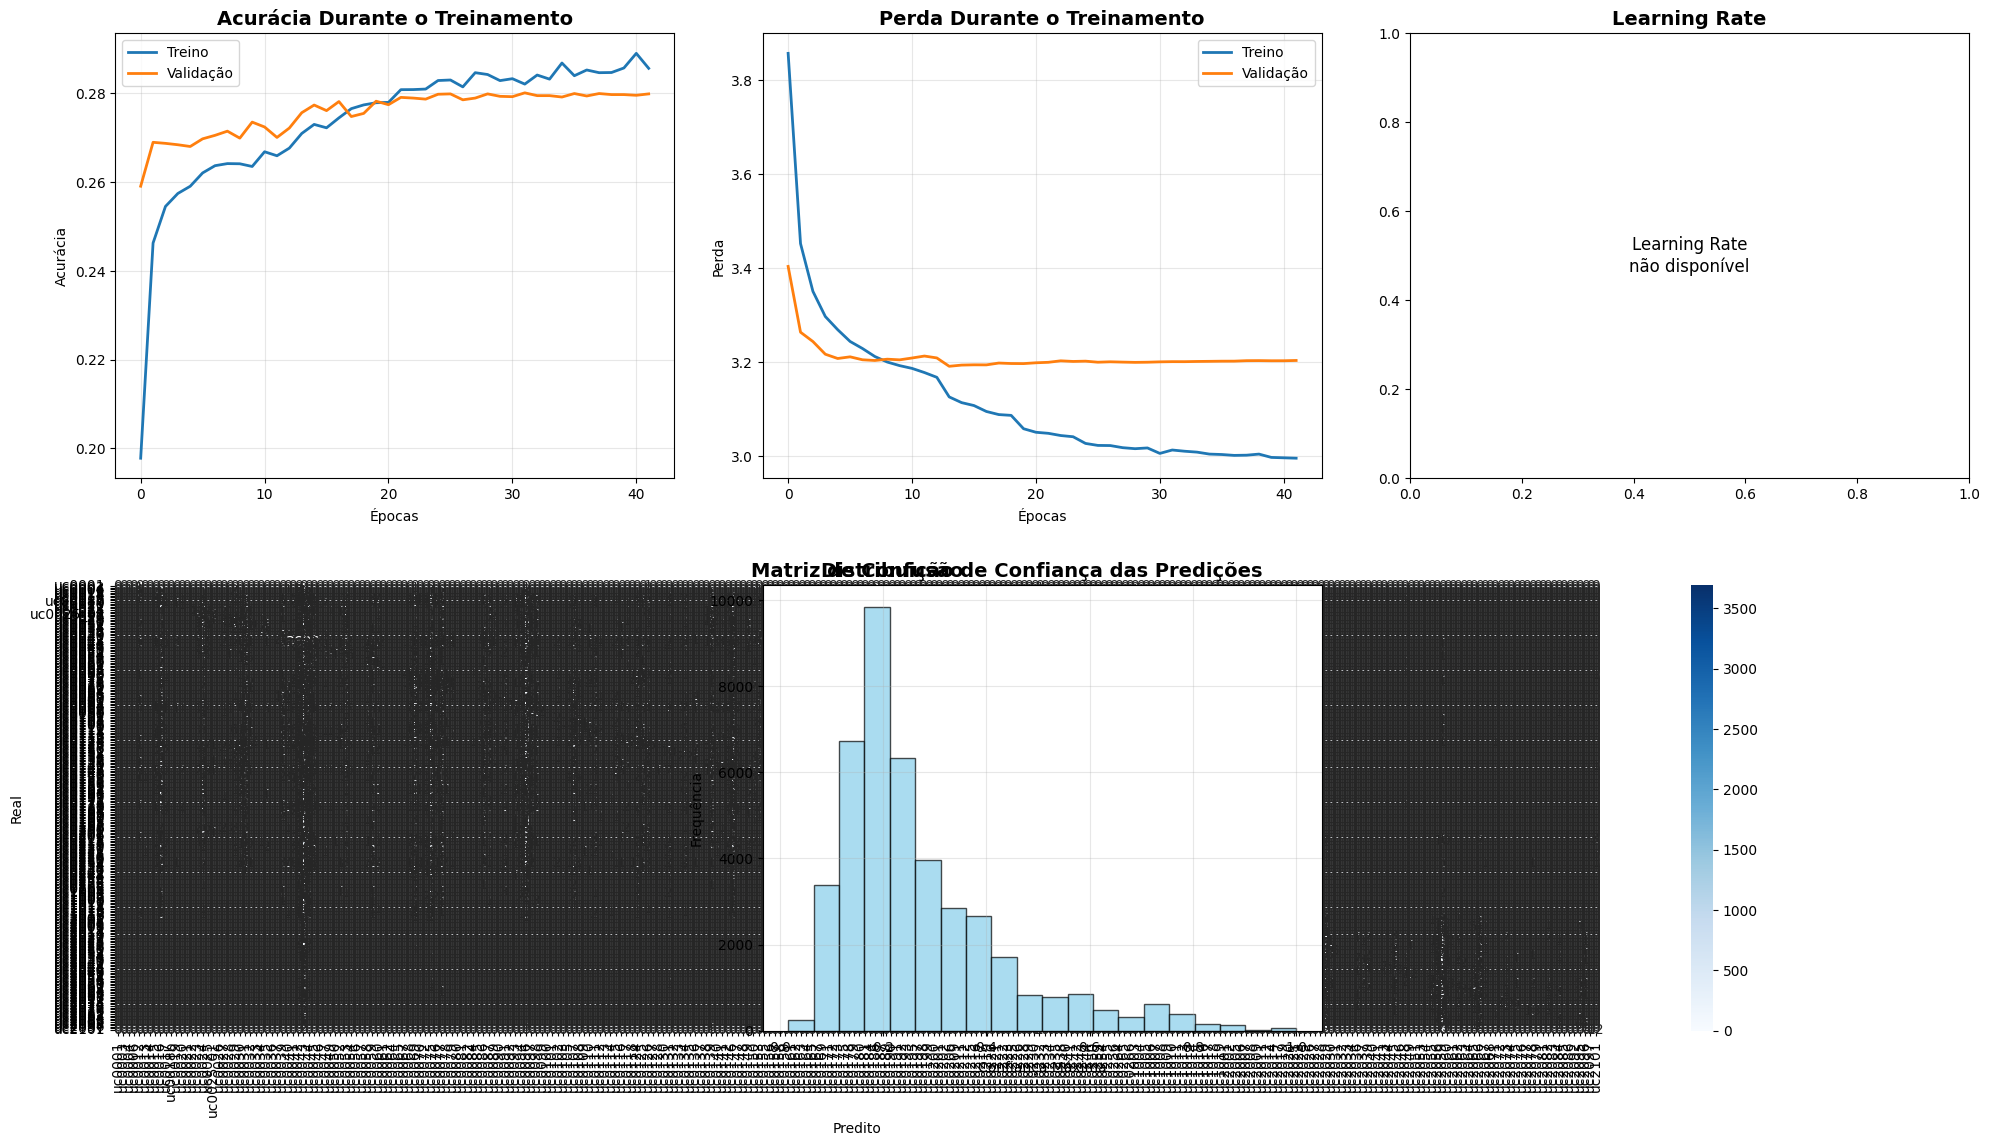


✅ Modelo e transformadores salvos na pasta 'modelos'!



Pipeline concluído com sucesso!
Acurácia final: 27.85%


In [16]:
print("\nIniciando pipeline de Machine Learning ...")
print("=" * 60)

# Executar todo o pipeline principal
modelo, historico, resultados = main(
    data_path='../dados/processados/Dados_TechChallenge_Fase3.csv', 
    usuario='*',  
    usuarios_exclusao=["usuario_00", "usuario_01", "usuario_02", "usuario_04", "usuario_06", "usuario_08", "usuario_11", "usuario_12", "usuario_13"],
    use_lstm=False,  
    epochs=50,
    plotar_resultado=True  
)

print("\n\n\nPipeline concluído com sucesso!")
print(f"Acurácia final: {resultados['accuracy']*100:.2f}%")

In [ ]:


def analisar_distribuicao_classes(serie_y, username):
    """
    Analisa a distribuição das classes para o usuário
    
    Args:
        serie_y: Série com os targets
        username: Nome do usuário
    
    Returns:
        dict: Estatísticas das classes
    """
    print(f"\n=== ANÁLISE DE CLASSES PARA {username} ===")
    
    class_counts = serie_y.value_counts()
    print(f"Total de classes: {len(class_counts)}")
    print(f"Total de amostras: {len(serie_y)}")
    print(f"Média de amostras por classe: {class_counts.mean():.1f}")
    print(f"Mediana de amostras por classe: {class_counts.median():.1f}")
    
    # Classes com poucas amostras
    classes_com_1_amostra = class_counts[class_counts == 1]
    classes_com_2_5_amostras = class_counts[(class_counts >= 2) & (class_counts <= 5)]
    
    print(f"\nClasses com 1 amostra: {len(classes_com_1_amostra)}")
    print(f"Classes com 2-5 amostras: {len(classes_com_2_5_amostras)}")
    print(f"Classes com 6+ amostras: {len(class_counts[class_counts > 5])}")
    
    if len(classes_com_1_amostra) > 0:
        print(f"\n⚠️ Classes problemáticas (1 amostra):")
        print(classes_com_1_amostra.head(10))
    
    # Top classes
    print(f"\n📊 Top 10 classes mais frequentes:")
    print(class_counts.head(10))
    
    return {
        'total_classes': len(class_counts),
        'total_samples': len(serie_y),
        'classes_with_one_sample': len(classes_com_1_amostra),
        'class_counts': class_counts
    }



def listar_usuarios(data_path):
    """
    retornar todos os usuários do arquivo
    
    Args:
        data_path: Caminho para o arquivo CSV
    
    Returns:
        list: Nomes de todos os usuários do arquivo
    """
    print("=== OBTENDO USUÁRIOS DO ARQUIVO ===")
    
    # Carregar dados
    df = pd.read_csv(
        data_path, 
        sep=';', 
        encoding='utf-8', 
        parse_dates=['DataHoraCriacao'], 
        dayfirst=True
    )
    
    return df['usuario'].unique()


def recomendar_usuarios(data_path, min_amostras=50, min_classes=5):
    """
    Analisa todos os usuários e recomenda os melhores para treinamento
    
    Args:
        data_path: Caminho para o arquivo CSV
        min_amostras: Número mínimo de amostras por usuário
        min_classes: Número mínimo de classes diferentes por usuário
    
    Returns:
        list: Lista de usuários recomendados ordenados por qualidade
    """
    print("=== ANALISANDO USUÁRIOS PARA RECOMENDAÇÃO ===")
    
    # Carregar dados
    df = pd.read_csv(
        data_path, 
        sep=';', 
        encoding='utf-8', 
        parse_dates=['DataHoraCriacao'], 
        dayfirst=True
    )
    
    usuarios_stats = []
    
    for usuario in df['usuario'].unique():
        df_user = df[df['usuario'] == usuario]
        class_counts = df_user['casoDeUso'].value_counts()
        
        # Calcular métricas de qualidade
        total_amostras = len(df_user)
        total_classes = len(class_counts)
        classes_com_uma_amostra = len(class_counts[class_counts == 1])
        classes_com_multiplas_amostras = len(class_counts[class_counts > 1])
        media_amostras_por_classe = class_counts.mean()
        balanceamento = 1 - (class_counts.std() / class_counts.mean()) if class_counts.mean() > 0 else 0
        
        # Score de qualidade (0-1, onde 1 é melhor)
        score_amostras = min(total_amostras / 200, 1.0)  # Normaliza até 200 amostras
        score_classes = min(total_classes / 20, 1.0)  # Normaliza até 20 classes
        score_balanceamento = max(0, balanceamento)  # Evita valores negativos
        score_sem_singletons = classes_com_multiplas_amostras / total_classes if total_classes > 0 else 0
        
        # Score final ponderado
        score_final = (
            0.3 * score_amostras + 
            0.3 * score_classes + 
            0.2 * score_balanceamento + 
            0.2 * score_sem_singletons
        )
        
        usuarios_stats.append({
            'usuario': usuario,
            'total_amostras': total_amostras,
            'total_classes': total_classes,
            'classes_com_uma_amostra': classes_com_uma_amostra,
            'classes_com_multiplas_amostras': classes_com_multiplas_amostras,
            'media_amostras_por_classe': media_amostras_por_classe,
            'balanceamento': balanceamento,
            'score_final': score_final
        })
    
    # Ordenar por score final
    usuarios_stats.sort(key=lambda x: x['score_final'], reverse=True)
    
    # Filtrar usuários que atendem critérios mínimos
    usuarios_validos = [
        u for u in usuarios_stats 
        if u['total_amostras'] >= min_amostras and u['total_classes'] >= min_classes
    ]
    
    print(f"\n📊 Top 10 usuários recomendados:")
    print("-" * 100)
    print(f"{'Usuário':<12} {'Amostras':<9} {'Classes':<8} {'Singleton':<10} {'Score':<8} {'Qualidade'}")
    print("-" * 100)
    
    for i, user_stats in enumerate(usuarios_validos[:10]):
        qualidade = "Excelente" if user_stats['score_final'] > 0.7 else "Boa" if user_stats['score_final'] > 0.5 else "Regular"
        print(f"{user_stats['usuario']:<12} {user_stats['total_amostras']:<9} {user_stats['total_classes']:<8} "
              f"{user_stats['classes_com_uma_amostra']:<10} {user_stats['score_final']:.3f}     {qualidade}")
    
    if not usuarios_validos:
        print("⚠️ Nenhum usuário atende os critérios mínimos especificados.")
        return usuarios_stats[:5]  # Retorna os 5 melhores mesmo que não atendam critérios
    
    return usuarios_validos


# =============================================================================
# CONSTRUÇÃO E TREINAMENTO DO MODELO
# =============================================================================



# =============================================================================
# AVALIAÇÃO E VISUALIZAÇÃO
# =============================================================================



# =============================================================================
# FUNÇÃO PRINCIPAL
# =============================================================================


# =============================================================================
# EXECUÇÃO
# =============================================================================

if __name__ == "__main__":
    print("🚀 Iniciando pipeline de Machine Learning melhorado...")
    print("=" * 60)
    
    # Testar Recomendar usuários
    # recomendar_usuarios(data_path='dados/Dados_TechChallenge_Fase3.csv');


    # Executar pipeline principal
    model, history, results = main(
        data_path='dados/Dados_TechChallenge_Fase3.csv',
        username='*',  # Pode usar "*" para todos os usuários ou "auto" para seleção automática
        usuarios_exclusao=["usuario_00", "usuario_01", "usuario_02", "usuario_04", "usuario_06", "usuario_08", "usuario_11", "usuario_12", "usuario_13"],
        use_lstm=False,  # Usar Dense layers (mais estável)
        epochs=50,
        auto_select_user=False  # True para seleção automática do melhor usuário
    )
    
    print("\n🎉 Pipeline concluído com sucesso!")
    print(f"📊 Acurácia final: {results['accuracy']*100:.2f}%")


if __name__ == "xx__main__":
    print("🚀 Iniciando pipeline de Machine Learning melhorado...")
    print("=" * 60)
    
    # Testar Listar usuários
    lista_usuarios = listar_usuarios(data_path='dados/Dados_TechChallenge_Fase3.csv')
    print(f"Usuários encontrados: {lista_usuarios}")
    print("=" * 60)
    
    # Dicionário para armazenar todos os resultados
    resultados_usuarios = {}
    
    # Loop através de todos os usuários
    for i, usuario in enumerate(lista_usuarios, 1):
        print(f"\n🔄 Processando usuário {i}/{len(lista_usuarios)}: {usuario}")
        print("-" * 40)
        
        try:
            model, history, results = main(
                data_path='dados/Dados_TechChallenge_Fase3.csv',
                username=usuario,
                use_lstm=False,  # Usar Dense layers (mais estável)
                epochs=50,
                auto_select_user=False,
                plotar_resultado=False
            )
            
            # Debug: verificar estrutura dos resultados
            print(f"🔍 Debug - Tipo de 'results': {type(results)}")
            print(f"🔍 Debug - Conteúdo de 'results': {results}")
            
            # Armazenar resultados do usuário
            resultados_usuarios[usuario] = {
                'model': model,
                'history': history,
                'results': results,
                'status': 'sucesso'
            }
            
            print(f"✅ Usuário {usuario} processado com sucesso!")
            
        except Exception as e:
            print(f"❌ Erro ao processar usuário {usuario}: {str(e)}")
            resultados_usuarios[usuario] = {
                'model': None,
                'history': None,
                'results': None,
                'status': 'erro',
                'erro': str(e)
            }
    
    print("\n" + "=" * 60)
    print("📊 COMPARAÇÃO DE RESULTADOS")
    print("=" * 60)
    
    # Comparar resultados
    usuarios_sucesso = []
    usuarios_erro = []
    
    for usuario, dados in resultados_usuarios.items():
        if dados['status'] == 'sucesso':
            usuarios_sucesso.append(usuario)
            results = dados['results']
            
            # Debug: verificar estrutura dos resultados antes da exibição
            print(f"\n🔍 Debug {usuario} - Tipo: {type(results)}, Conteúdo: {results}")
            
            # Tentar diferentes formas de acessar as métricas
            mae_val = None
            mse_val = None
            rmse_val = None
            r2_val = None
            
            if isinstance(results, dict):
                mae_val = results.get('mae')
                mse_val = results.get('mse') 
                rmse_val = results.get('rmse')
                r2_val = results.get('r2')
            elif isinstance(results, (list, tuple)) and len(results) >= 4:
                mae_val, mse_val, rmse_val, r2_val = results[:4]
            elif hasattr(results, 'mae'):
                mae_val = getattr(results, 'mae', None)
                mse_val = getattr(results, 'mse', None)
                rmse_val = getattr(results, 'rmse', None)
                r2_val = getattr(results, 'r2', None)
            
            print(f"\n👤 Usuário: {usuario}")
            print(f"   📈 MAE: {mae_val:.4f}" if isinstance(mae_val, (int, float)) else f"   📈 MAE: {mae_val}")
            print(f"   📈 MSE: {mse_val:.4f}" if isinstance(mse_val, (int, float)) else f"   📈 MSE: {mse_val}")
            print(f"   📈 RMSE: {rmse_val:.4f}" if isinstance(rmse_val, (int, float)) else f"   📈 RMSE: {rmse_val}")
            print(f"   📈 R²: {r2_val:.4f}" if isinstance(r2_val, (int, float)) else f"   📈 R²: {r2_val}")
        else:
            usuarios_erro.append(usuario)
            print(f"\n❌ Usuário: {usuario} - ERRO: {dados['erro']}")
    
    # Encontrar o melhor usuário baseado em R²
    if usuarios_sucesso:
        print("\n" + "=" * 60)
        print("🏆 RANKING DOS MELHORES RESULTADOS")
        print("=" * 60)
        
        # Criar lista de usuários com suas métricas para ranking
        usuarios_com_metricas = []
        for usuario in usuarios_sucesso:
            results = resultados_usuarios[usuario]['results']
            
            # Extrair R² usando a mesma lógica de debug
            r2_score = -999  # Valor baixo como padrão
            
            if isinstance(results, dict):
                r2_score = results.get('r2', -999)
            elif isinstance(results, (list, tuple)) and len(results) >= 4:
                r2_score = results[3] if results[3] is not None else -999
            elif hasattr(results, 'r2'):
                r2_score = getattr(results, 'r2', -999)
            
            if isinstance(r2_score, (int, float)):
                usuarios_com_metricas.append((usuario, r2_score, results))
        
        # Ordenar por R² (maior é melhor)
        usuarios_com_metricas.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n🥇 TOP 3 USUÁRIOS:")
        for i, (usuario, r2_score, results) in enumerate(usuarios_com_metricas[:3], 1):
            emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
            
            # Extrair métricas usando a mesma lógica
            mae_val = mse_val = rmse_val = None
            
            if isinstance(results, dict):
                mae_val = results.get('mae')
                mse_val = results.get('mse')
                rmse_val = results.get('rmse')
            elif isinstance(results, (list, tuple)) and len(results) >= 4:
                mae_val, mse_val, rmse_val, _ = results[:4]
            elif hasattr(results, 'mae'):
                mae_val = getattr(results, 'mae', None)
                mse_val = getattr(results, 'mse', None)
                rmse_val = getattr(results, 'rmse', None)
            
            print(f"{emoji} {i}º lugar - {usuario}")
            print(f"    R²: {r2_score:.4f}")
            print(f"    MAE: {mae_val:.4f}" if isinstance(mae_val, (int, float)) else f"    MAE: {mae_val}")
            print(f"    RMSE: {rmse_val:.4f}" if isinstance(rmse_val, (int, float)) else f"    RMSE: {rmse_val}")
        
        melhor_usuario = usuarios_com_metricas[0][0]
        print(f"\n🎯 MELHOR MODELO: {melhor_usuario}")
        
    # Resumo estatístico
    print("\n" + "=" * 60)
    print("📋 RESUMO ESTATÍSTICO")
    print("=" * 60)
    print(f"Total de usuários processados: {len(lista_usuarios)}")
    print(f"Sucessos: {len(usuarios_sucesso)}")
    print(f"Erros: {len(usuarios_erro)}")
    print(f"Taxa de sucesso: {len(usuarios_sucesso)/len(lista_usuarios)*100:.1f}%")
    
    if usuarios_erro:
        print(f"\nUsuários com erro: {', '.join(usuarios_erro)}")
    
    # Salvar resultados em variável global para acesso posterior
    globals()['resultados_completos'] = resultados_usuarios
    
    print("\n✅ Pipeline concluído! Resultados salvos em 'resultados_completos'")
    print("💡 Use 'resultados_completos[\"nome_usuario\"]' para acessar resultados específicos")

if __name__ == "xx__main__":
    print("🚀 Iniciando pipeline de Machine Learning melhorado...")
    print("=" * 60)
    
    # Testar Listar usuários
    lista_usuarios = listar_usuarios(data_path='dados/Dados_TechChallenge_Fase3.csv')
    print(f"Usuários encontrados: {lista_usuarios}")
    print("=" * 60)
    
    # Dicionário para armazenar todos os resultados
    resultados_usuarios = {}
    
    # Loop através de todos os usuários
    for i, usuario in enumerate(lista_usuarios, 1):
        print(f"\n🔄 Processando usuário {i}/{len(lista_usuarios)}: {usuario}")
        print("-" * 40)
        
        try:
            model, history, results = main(
                data_path='dados/Dados_TechChallenge_Fase3.csv',
                username=usuario,
                use_lstm=False,  # Usar Dense layers (mais estável)
                epochs=50,
                auto_select_user=False,
                plotar_resultado=False
            )
            
            # Debug: verificar estrutura dos resultados
            print(f"🔍 Debug - Tipo de 'results': {type(results)}")
            print(f"🔍 Debug - Chaves disponíveis: {list(results.keys()) if isinstance(results, dict) else 'N/A'}")
            
            # Armazenar resultados do usuário
            resultados_usuarios[usuario] = {
                'model': model,
                'history': history,
                'results': results,
                'status': 'sucesso'
            }
            
            print(f"✅ Usuário {usuario} processado com sucesso!")
            
        except Exception as e:
            print(f"❌ Erro ao processar usuário {usuario}: {str(e)}")
            resultados_usuarios[usuario] = {
                'model': None,
                'history': None,
                'results': None,
                'status': 'erro',
                'erro': str(e)
            }
    
    print("\n" + "=" * 60)
    print("📊 COMPARAÇÃO DE RESULTADOS")
    print("=" * 60)
    
    # Comparar resultados
    usuarios_sucesso = []
    usuarios_erro = []
    
    for usuario, dados in resultados_usuarios.items():
        if dados['status'] == 'sucesso':
            usuarios_sucesso.append(usuario)
            results = dados['results']
            
            # Extrair métricas de classificação
            accuracy = results.get('accuracy', 'N/A')
            confusion_matrix = results.get('confusion_matrix', 'N/A')
            class_names = results.get('class_names', 'N/A')
            
            # Calcular métricas adicionais da matriz de confusão
            precision = recall = f1_score = 'N/A'
            
            if isinstance(confusion_matrix, type(results.get('confusion_matrix'))) and hasattr(confusion_matrix, 'shape'):
                try:
                    # Para classificação binária
                    tn, fp, fn, tp = confusion_matrix.ravel()
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                except:
                    pass
            
            print(f"\n👤 Usuário: {usuario}")
            print(f"   🎯 Accuracy: {accuracy:.4f}" if isinstance(accuracy, (int, float)) else f"   🎯 Accuracy: {accuracy}")
            print(f"   📊 Precision: {precision:.4f}" if isinstance(precision, (int, float)) else f"   📊 Precision: {precision}")
            print(f"   📊 Recall: {recall:.4f}" if isinstance(recall, (int, float)) else f"   📊 Recall: {recall}")
            print(f"   📊 F1-Score: {f1_score:.4f}" if isinstance(f1_score, (int, float)) else f"   📊 F1-Score: {f1_score}")
            print(f"   🏷️ Classes: {class_names}")
        else:
            usuarios_erro.append(usuario)
            print(f"\n❌ Usuário: {usuario} - ERRO: {dados['erro']}")
    
    # Encontrar o melhor usuário baseado em R²
    if usuarios_sucesso:
        print("\n" + "=" * 60)
        print("🏆 RANKING DOS MELHORES RESULTADOS")
        print("=" * 60)
        
        # Criar lista de usuários com suas métricas para ranking
        usuarios_com_metricas = []
        for usuario in usuarios_sucesso:
            results = resultados_usuarios[usuario]['results']
            
            # Usar accuracy como métrica principal para ranking
            accuracy_score = results.get('accuracy', 0)
            
            if isinstance(accuracy_score, (int, float)):
                usuarios_com_metricas.append((usuario, accuracy_score, results))
        
        # Ordenar por Accuracy (maior é melhor)
        usuarios_com_metricas.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n🥇 TOP 3 USUÁRIOS:")
        for i, (usuario, accuracy_score, results) in enumerate(usuarios_com_metricas[:3], 1):
            emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
            
            # Calcular métricas adicionais
            confusion_matrix = results.get('confusion_matrix')
            precision = recall = f1_score = 'N/A'
            
            if hasattr(confusion_matrix, 'ravel'):
                try:
                    tn, fp, fn, tp = confusion_matrix.ravel()
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                except:
                    pass
            
            print(f"{emoji} {i}º lugar - {usuario}")
            print(f"    🎯 Accuracy: {accuracy_score:.4f}")
            print(f"    📊 Precision: {precision:.4f}" if isinstance(precision, (int, float)) else f"    📊 Precision: {precision}")
            print(f"    📊 F1-Score: {f1_score:.4f}" if isinstance(f1_score, (int, float)) else f"    📊 F1-Score: {f1_score}")
        
        melhor_usuario = usuarios_com_metricas[0][0]
        print(f"\n🎯 MELHOR MODELO: {melhor_usuario} (Accuracy: {usuarios_com_metricas[0][1]:.4f})")
        
    # Resumo estatístico
    print("\n" + "=" * 60)
    print("📋 RESUMO ESTATÍSTICO")
    print("=" * 60)
    print(f"Total de usuários processados: {len(lista_usuarios)}")
    print(f"Sucessos: {len(usuarios_sucesso)}")
    print(f"Erros: {len(usuarios_erro)}")
    print(f"Taxa de sucesso: {len(usuarios_sucesso)/len(lista_usuarios)*100:.1f}%")
    
    if usuarios_erro:
        print(f"\nUsuários com erro: {', '.join(usuarios_erro)}")
    
    # Salvar resultados em variável global para acesso posterior
    globals()['resultados_completos'] = resultados_usuarios
    
    print("\n✅ Pipeline concluído! Resultados salvos em 'resultados_completos'")
    print("💡 Use 'resultados_completos[\"nome_usuario\"]' para acessar resultados específicos")
